In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import tensorflow as tf
import scipy
from matplotlib.collections import LineCollection
from scipy.stats import wilcoxon

In [2]:
posPatients = np.concatenate((np.array([2,4,5,7,9,11,12,13,16,17,18,19,21,22]),range(23,52),np.array([55]),
                                range(60,63),range(64,74),range(75,82),range(83,104),range(105,109)))
locList = []
maskList = []
posList = []
img_height=128
limit=0.25
pixLimit=5

for i in range(len(posPatients)):
    if posPatients[i]<23:
        if posPatients[i]==12:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
        else:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        if posPatients[i]==23:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/23/23_maski/23_nifti_maski_edit.img'
        if posPatients[i]==24:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/24/24_maski/24_maski.img'
        if posPatients[i]==38:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/38/38_nifti_maski/38_nifti_maski_edit.img'
        if posPatients[i] not in [23,24,38]:    
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_maski/{}_nifti_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    locations = []
    masks = []
    for j in range(img_data.shape[2]):
        slice = np.array(img_data[:,:,j])
        if np.max(slice)>0:
            slice=cv2.resize(slice,(img_height,img_height))
            for k in range(img_height):
                for l in range(img_height):
                    if slice[k,l]>limit:
                        slice[k,l]=1
                    else:
                        slice[k,l]=0
            if np.sum(slice)>pixLimit:
                locations.append(j)
                masks.append(slice)
    locList.append(np.array(locations))
    maskList.append(masks)

for i in range(len(posPatients)):
    if posPatients[i]<23:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    pos = []
    for j in range(len(locList[i])):
        pos.append(cv2.resize(np.array(img_data[:,:,locList[i][j]]),(img_height,img_height)))
    posList.append(pos)

def convert(img):

    img=(img-np.min(img))/(np.max(img)-np.min(img))*255
    for i in range(img_height):
        for j in range(img_height):
            img[i,j]=int(img[i,j])
    return img.astype('int64')

for i in range(len(posList)):
    for j in range(len(posList[i])):
        posList[i][j]=convert(posList[i][j])

In [3]:
numberOfSlices=[]
finPatients=0
for i in range(len(posList)):
    numberOfSlices.append(len(posList[i]))
    if len(posList[i])>0:
        finPatients+=1
numberOfSlices=np.array(numberOfSlices)
print(finPatients)
print(sum(numberOfSlices))
print(np.mean(numberOfSlices))
print(np.std(numberOfSlices))
print(numberOfSlices)

89
962
10.808988764044944
6.063107084385669
[ 3  9 11 14  8  9 15 12  5 10 13  8 11 10  4 13  4  4  6  4  6  6  5 12
 12  6 18 18  6 19  7 12 13 22 10  5 20  5 12 25  5  7  2  9  6 18 24 11
 11 13 21  7  6  9 13  5  2  1  7  3 18 15  6 20 26 16 13 10 11  6  3  4
 15  6 26  6 10 10 20  5 17 13 18 13 14 11  4 11 23]


In [4]:
testSetPatients=np.concatenate((range(0,70,5),np.array([72,82,83])))

numTestSetSlices=0
numTestSetPatients=0
for i in range(len(posList)):
    if i in testSetPatients:
        numTestSetSlices+=len(posList[i])
        if len(posList[i])>0:
            numTestSetPatients+=1

print(numTestSetSlices)
print(numTestSetSlices/sum(numberOfSlices))
print(numTestSetPatients)

191
0.19854469854469856
17


In [5]:
x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(posList)):
    if i in testSetPatients:
        for j in range(len(posList[i])):
            img=(posList[i][j]-np.min(posList[i][j]))/(np.max(posList[i][j])-np.min(posList[i][j]))
            x_test.append(img)
            y_test.append(cv2.resize(maskList[i][j],(img_height,img_height)))   
    else:
        for j in range(len(posList[i])):
            img=(posList[i][j]-np.min(posList[i][j]))/(np.max(posList[i][j])-np.min(posList[i][j]))
            x_train.append(img)
            y_train.append(cv2.resize(maskList[i][j],(img_height,img_height)))  

x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [6]:
#Unet CNN for segmentation

def unetForSegmentation(shape):

    img_height=shape[1]
    if len(shape)==4:
        chl_number=shape[3]
    else:
        chl_number=1

    #U-Net model
    inputs = tf.keras.layers.Input(shape=(img_height,img_height,chl_number))

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    #Expansive path
    u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.1)(c7)
    c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='linear')(c9) #sigmoid or linear

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

Epoch 1/50
17/17 [==============================] - 57s 3s/step - loss: 0.0936 - val_loss: 0.0767
Epoch 2/50
17/17 [==============================] - 52s 3s/step - loss: 0.0935 - val_loss: 0.0767
Epoch 3/50
17/17 [==============================] - 52s 3s/step - loss: 0.0935 - val_loss: 0.0767
Epoch 4/50
17/17 [==============================] - 52s 3s/step - loss: 0.0894 - val_loss: 0.0736
Epoch 5/50
17/17 [==============================] - 52s 3s/step - loss: 0.0540 - val_loss: 0.0290
Epoch 6/50
17/17 [==============================] - 53s 3s/step - loss: 0.0292 - val_loss: 0.0184
Epoch 7/50
17/17 [==============================] - 53s 3s/step - loss: 0.0242 - val_loss: 0.0176
Epoch 8/50
17/17 [==============================] - 53s 3s/step - loss: 0.0230 - val_loss: 0.0178
Epoch 9/50
17/17 [==============================] - 52s 3s/step - loss: 0.0215 - val_loss: 0.0165
Epoch 10/50
17/17 [==============================] - 53s 3s/step - loss: 0.0203 - val_loss: 0.0162
Epoch 11/50
17/17 [

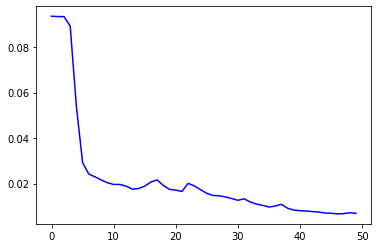

In [61]:
model=unetForSegmentation(x_test.shape)
numEpochs=50
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=30, restore_best_weights=True)
history=model.fit(x=x_train,y=y_train,epochs=numEpochs,validation_split=0.3,callbacks=[earlystopping],shuffle=True)
trainPredictions=model.predict(x_train)
predictions=model.predict(x_test)
plt.plot(range(len(history.history['loss'])),history.history['loss'],color='blue')

In [7]:
def dicesForLimit(predictions,y_test,limit):

    dices=np.zeros((len(y_test)))

    img_height=predictions[0].shape[0]

    for k in range(len(y_test)):
        TP=0
        FN=0
        FP=0
        for i in range(img_height):
            for j in range(img_height):
                if y_test[k,i,j]>0.5 and predictions[k,i,j]>limit:
                    TP+=1
                if y_test[k,i,j]>0.5 and predictions[k,i,j]<limit:
                    FN+=1
                if y_test[k,i,j]<0.5 and predictions[k,i,j]>limit:
                    FP+=1
        if TP+FN+FP>0:
            dices[k]=2*TP/(2*TP+FN+FP)

    return(dices)

In [68]:
limit=0.40
dices=dicesForLimit(trainPredictions,y_train,limit)
print(np.median(dices))
print(np.mean(dices))

#0.30 0.722 / 0.651
#0.35 0.745 / 0.666
#0.37 0.753 / 0.669
#0.40 0.759 / 0.671
#0.43 0.757 / 0.667
#0.45 0.757 / 0.665

0.759493670886076
0.6713943965565415


In [12]:
limit=0.40
dices=dicesForLimit(predictions,y_test,limit)
print(np.median(dices))
print(np.mean(dices))
print(np.min(dices))
print(np.max(dices))

0.6229508196721312
0.5416179104010125
0.0
0.9803921568627451


In [70]:
for i in range(len(predictions)):
    np.savetxt('predictions_{}.txt'.format(i), predictions[i][:,:,0])

In [6]:
def get_all_edges(bool_img):
    """
    Get a list of all edges (where the value changes from True to False) in the 2D boolean image.
    The returned array edges has he dimension (n, 2, 2).
    Edge i connects the pixels edges[i, 0, :] and edges[i, 1, :].
    Note that the indices of a pixel also denote the coordinates of its lower left corner.
    """
    edges = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            edges.append(np.array([[i, j+1],
                                   [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            edges.append(np.array([[i+1, j],
                                   [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            edges.append(np.array([[i, j],
                                   [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            edges.append(np.array([[i, j],
                                   [i, j+1]]))

    if not edges:
        return np.zeros((0, 2, 2))
    else:
        return np.array(edges)


def close_loop_edges(edges):
    """
    Combine the edges defined by 'get_all_edges' to closed loops around objects.
    If there are multiple disconnected objects a list of closed loops is returned.
    Note that it's expected that all the edges are part of exactly one loop (but not necessarily the same one).
    """

    loop_list = []
    while edges.size != 0:

        loop = [edges[0, 0], edges[0, 1]]  # Start with first edge
        edges = np.delete(edges, 0, axis=0)

        while edges.size != 0:
            # Get next edge (=edge with common node)
            ij = np.nonzero((edges == loop[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                loop.append(loop[0])
                # Uncomment to to make the start of the loop invisible when plotting
                # loop.append(loop[1])
                break

            loop.append(edges[i, (j + 1) % 2, :])
            edges = np.delete(edges, i, axis=0)

        loop_list.append(np.array(loop))

    return loop_list


def plot_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    edges = get_all_edges(bool_img=bool_img)
    edges = edges - 0.5  # convert indices to coordinates; TODO adjust according to image extent
    outlines = close_loop_edges(edges=edges)
    cl = LineCollection(outlines, **kwargs)
    ax.add_collection(cl)

In [7]:
def turnIntoBinaryMask(img,lim):

    img_height=img.shape[0]

    binM=np.zeros((img_height,img_height))

    for i in range(img_height):
        for j in range(img_height):
            if img[i][j]>lim:
                binM[i][j]=1
    
    return binM

In [ ]:
for i in range(len(predictions)):
    array=cv2.rotate(y_test[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    array1=cv2.rotate(turnIntoBinaryMask(predictions[i],limit),cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(array1)
    plt.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE), cmap='gray')
    plot_outlines(array.T, lw=2, color='green')
    plot_outlines(array1.T, lw=2, color='blue')
    plt.savefig('fig{}.png'.format(i),bbox_inches='tight')
    plt.show()

In [8]:
predictions=[]
for i in range(len(y_test)):
    predictions.append(np.loadtxt('predictions_{}.txt'.format(i)))
predictions=np.array(predictions)

In [9]:
classifications=np.array([2, 1, 1, 4, 4, 4, 2, 2, 2, 2, 1, 0, 3, 4, 3, 4, 2, 2, 2, 2, 2, 3,
       3, 3, 4, 1, 1, 2, 3, 2, 4, 3, 3, 3, 3, 3, 3, 0, 3, 4, 4, 4, 4, 3,
       2, 4, 2, 2, 2, 1, 0, 3, 4, 4, 4, 3, 3, 4, 2, 2, 1, 1, 3, 4, 4, 4,
       3, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 2, 4, 2, 2, 4, 3, 4, 4, 4, 4, 4, 3, 3, 0, 0, 1,
       4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 2, 4, 4, 4, 3, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 4, 4, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2,
       2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 3, 3])

In [50]:
for i in range(1,17):
    if i*12-12<=77 and 77<i*12:
        print(i)
        print(classifications[(i*12-12):(i*12)])

7
[1 2 1 1 1 2 1 1 1 0 0 0]


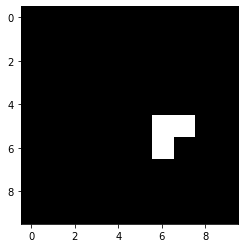

In [10]:
x=np.zeros((10,10))
x[5,5]=1
x[5,6]=1
x[4,5]=1
x[4,4]=1
x[5,4]=1
x[4,3]=1
y=np.zeros((10,10))
y[5,6]=1
y[5,7]=1
y[6,6]=1
plt.imshow(y,cmap='gray')

In [11]:
def findDice(x,y):

    minImg=np.array([x,y]).min(axis=0)
    return(2*np.sum(minImg)/(np.sum(x)+np.sum(y)))

def findMinDice(x,y):
    
    x7=scipy.ndimage.morphology.binary_dilation(x)
    x5=scipy.ndimage.morphology.binary_dilation(x7)
    x3=scipy.ndimage.morphology.binary_dilation(x5)
    img=np.array([x,0.7*x7,0.5*x5,0.3*x3]).max(axis=0)

    y7=scipy.ndimage.morphology.binary_dilation(y)
    y5=scipy.ndimage.morphology.binary_dilation(y7)
    y3=scipy.ndimage.morphology.binary_dilation(y5)
    img1=np.array([y,0.7*y7,0.5*y5,0.3*y3]).max(axis=0)

    minImg=np.array([img,img1]).min(axis=0)

    return(2*np.sum(minImg)/(np.sum(img)+np.sum(img1)))

def findDistDice(x,y):

    minImg=np.array([x,y]).min(axis=0)
    
    x1=scipy.ndimage.morphology.binary_dilation(x)
    x1=scipy.ndimage.morphology.binary_dilation(x1)
    x1=scipy.ndimage.morphology.binary_dilation(x1)

    y1=scipy.ndimage.morphology.binary_dilation(y)
    y1=scipy.ndimage.morphology.binary_dilation(y1)
    y1=scipy.ndimage.morphology.binary_dilation(y1)

    s=0
    if len(x.shape)==2:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if x1[i,j]==0 or y1[i,j]==0:
                    s+=x[i,j]+y[i,j]
    else:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                for k in range(x.shape[2]):
                    if x1[i,j,k]==0 or y1[i,j,k]==0:
                        s+=x[i,j,k]+y[i,j,k]

    return(2*np.sum(minImg)/(np.sum(x)+np.sum(y)+s))

print(findDice(x,y))
print(findMinDice(x,y))
print(findDistDice(x,y))

0.2222222222222222
0.6000000000000001
0.2


In [12]:
limit=0.40

dices=[]
minDices=[]
distDices=[]

for i in range(len(predictions)):
    dices.append(findDice(y_test[i],turnIntoBinaryMask(predictions[i],limit)))
    minDices.append(findMinDice(y_test[i],turnIntoBinaryMask(predictions[i],limit)))
    distDices.append(findDistDice(y_test[i],turnIntoBinaryMask(predictions[i],limit)))

dices=np.array(dices)
minDices=np.array(minDices)
distDices=np.array(distDices)

In [13]:
dices0=[]
dices1=[]
dices2=[]
dices3=[]
dices4=[]
for i in range(len(y_test)):
    if classifications[i]==0:
        dices0.append(dices[i])
    if classifications[i]==1:
        dices1.append(dices[i])
    if classifications[i]==2:
        dices2.append(dices[i])
    if classifications[i]==3:
        dices3.append(dices[i])
    if classifications[i]==4:
        dices4.append(dices[i])
dicesForClass=[dices0,dices1,dices2,dices3,dices4]

dices0=[]
dices1=[]
dices2=[]
dices3=[]
dices4=[]
for i in range(len(y_test)):
    if classifications[i]==0:
        dices0.append(minDices[i])
    if classifications[i]==1:
        dices1.append(minDices[i])
    if classifications[i]==2:
        dices2.append(minDices[i])
    if classifications[i]==3:
        dices3.append(minDices[i])
    if classifications[i]==4:
        dices4.append(minDices[i])
minDicesForClass=[dices0,dices1,dices2,dices3,dices4]

dices0=[]
dices1=[]
dices2=[]
dices3=[]
dices4=[]
for i in range(len(y_test)):
    if classifications[i]==0:
        dices0.append(distDices[i])
    if classifications[i]==1:
        dices1.append(distDices[i])
    if classifications[i]==2:
        dices2.append(distDices[i])
    if classifications[i]==3:
        dices3.append(distDices[i])
    if classifications[i]==4:
        dices4.append(distDices[i])
distDicesForClass=[dices0,dices1,dices2,dices3,dices4]

In [26]:
for i in range(5):
    print(i)
    #print(len(minDicesForClass[i]))
    print(round(np.min(dicesForClass[i]),3),' | ',round(np.min(minDicesForClass[i]),3),' | ',round(np.min(distDicesForClass[i]),3))
    print(round(np.mean(dicesForClass[i]),3),' | ',round(np.mean(minDicesForClass[i]),3),' | ',round(np.mean(distDicesForClass[i]),3))
    print(round(np.max(dicesForClass[i]),3),' | ',round(np.max(minDicesForClass[i]),3),' | ',round(np.max(distDicesForClass[i]),3))
    print(round(np.std(dicesForClass[i]),3),' | ',round(np.std(minDicesForClass[i]),3),' | ',round(np.std(distDicesForClass[i]),3))

0
0.0  |  0.0  |  0.0
0.0  |  0.002  |  0.0
0.0  |  0.027  |  0.0
0.0  |  0.006  |  0.0
1
0.045  |  0.142  |  0.023
0.324  |  0.41  |  0.248
0.857  |  0.791  |  0.811
0.214  |  0.175  |  0.197
2
0.091  |  0.212  |  0.054
0.545  |  0.605  |  0.468
0.856  |  0.841  |  0.824
0.198  |  0.155  |  0.214
3
0.255  |  0.482  |  0.182
0.653  |  0.734  |  0.62
0.874  |  0.891  |  0.854
0.134  |  0.091  |  0.145
4
0.605  |  0.747  |  0.605
0.825  |  0.874  |  0.824
0.98  |  0.991  |  0.98
0.078  |  0.053  |  0.079


In [27]:
for i in range(5):
    print(i)
    #print(len(minDicesForClass[i]))
    print(round(np.max(dicesForClass[i])-np.min(dicesForClass[i]),3),' | ',
          round(np.max(minDicesForClass[i])-np.min(minDicesForClass[i]),3),' | ',
          round(np.max(distDicesForClass[i])-np.min(distDicesForClass[i]),3))

0
0.0  |  0.027  |  0.0
1
0.812  |  0.648  |  0.787
2
0.765  |  0.629  |  0.771
3
0.618  |  0.409  |  0.672
4
0.376  |  0.244  |  0.376


In [32]:
def f_test(x,y):

    x=np.array(x)
    y=np.array(y)
    f=np.var(x,ddof=1)/np.var(y,ddof=1)
    dfn=x.size-1
    dfd=y.size-1
    p=2*min(1-scipy.stats.f.cdf(f,dfn,dfd),scipy.stats.f.cdf(f,dfn,dfd))
    return(p)

#for i in range(1,5):
    #print(f_test(dicesForClass[i],minDicesForClass[i]))

#for i in range(1,5):
    #print(f_test(dicesForClass[i],distDicesForClass[i]))

for i in range(1,5):
    print(f_test(minDicesForClass[i],distDicesForClass[i]))

0.5434227864172948
0.03691053513079565
0.004289037910039299
0.004658760618544159


In [14]:
testSetSlices=[]
numTestSetPatients=0
for i in range(len(posList)):
    if i in testSetPatients:
        testSetSlices.append(len(posList[i]))
print(testSetSlices)

classifications3d=[]
masks3d=[]
predictions3d=[]

k=0
for i in range(len(testSetSlices)):
    v=[]
    mask=[]
    pred=[]
    for j in range(testSetSlices[i]):
        v.append(classifications[k])
        mask.append(y_test[k])
        pred.append(turnIntoBinaryMask(predictions[k],0.40))
        k+=1
    v=np.array(v)
    classifications3d.append(v)
    mask=np.array(mask)
    masks3d.append(mask)
    pred=np.array(pred)
    predictions3d.append(pred)

[3, 9, 13, 13, 6, 6, 7, 5, 5, 18, 21, 5, 18, 16, 15, 18, 13]


In [67]:
for i in range(len(testSetSlices)):
    print(testSetSlices[i],' & ',
          round(np.mean(classifications3d[i]),1),' & ',
          round(findDice(masks3d[i],predictions3d[i]),3),' & ',
          round(findMinDice(masks3d[i],predictions3d[i]),3),' & ',
          round(findDistDice(masks3d[i],predictions3d[i]),3),'\\\\')

3  &  1.3  &  0.365  &  0.492  &  0.235 \\
9  &  2.3  &  0.703  &  0.675  &  0.614 \\
13  &  2.8  &  0.744  &  0.826  &  0.726 \\
13  &  2.4  &  0.722  &  0.794  &  0.703 \\
6  &  3.7  &  0.819  &  0.89  &  0.819 \\
6  &  2.2  &  0.603  &  0.6  &  0.528 \\
7  &  3.0  &  0.682  &  0.722  &  0.641 \\
5  &  2.0  &  0.599  &  0.525  &  0.461 \\
5  &  3.6  &  0.71  &  0.795  &  0.702 \\
18  &  0.8  &  0.175  &  0.316  &  0.105 \\
21  &  1.5  &  0.431  &  0.526  &  0.336 \\
5  &  3.8  &  0.789  &  0.879  &  0.789 \\
18  &  3.5  &  0.779  &  0.865  &  0.779 \\
16  &  3.1  &  0.751  &  0.798  &  0.731 \\
15  &  2.5  &  0.505  &  0.602  &  0.424 \\
18  &  2.5  &  0.64  &  0.73  &  0.605 \\
13  &  1.2  &  0.101  &  0.192  &  0.057 \\


In [ ]:
i=0
print(i,classifications[i],round(dices[i],3),round(minDices[i],3),round(distDices[i],3))
array=cv2.rotate(y_test[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
array1=cv2.rotate(turnIntoBinaryMask(predictions[i],limit),cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(array1)
plt.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE), cmap='gray')
fig=plt.gcf()
plot_outlines(array.T, lw=2, color='green')
plot_outlines(array1.T, lw=2, color='blue')
plt.axis('off')
#plt.savefig('fig{}.png'.format(i),bbox_inches='tight')
plt.show()
#plt.imshow(array, cmap='gray')
#plt.show()
#plt.imshow(array1, cmap='gray')
#plt.show()

In [16]:
print(scipy.stats.spearmanr(classifications,dices))
print(scipy.stats.spearmanr(classifications,minDices))
print(scipy.stats.spearmanr(classifications,distDices))

SpearmanrResult(correlation=0.8320902026321286, pvalue=2.884847457366621e-50)
SpearmanrResult(correlation=0.8925781214528374, pvalue=2.7024636974113724e-67)
SpearmanrResult(correlation=0.8673217494585266, pvalue=3.62238032447915e-59)


In [17]:
dices3d=[]
minDices3d=[]
distDices3d=[]
scores3d=[]

for i in range(len(testSetSlices)):
    dices3d.append(findDice(masks3d[i],predictions3d[i]))
    minDices3d.append(findMinDice(masks3d[i],predictions3d[i]))
    distDices3d.append(findDistDice(masks3d[i],predictions3d[i]))
    scores3d.append(np.mean(classifications3d[i]))

dices3d=np.array(dices3d)
minDices3d=np.array(minDices3d)
distDices3d=np.array(distDices3d)
scores3d=np.array(scores3d)

print(scipy.stats.spearmanr(scores3d,dices3d))
print(scipy.stats.spearmanr(scores3d,minDices3d))
print(scipy.stats.spearmanr(scores3d,distDices3d))

SpearmanrResult(correlation=0.8995098039215688, pvalue=8.964818375507006e-07)
SpearmanrResult(correlation=0.9411764705882353, pvalue=1.8275574906300595e-08)
SpearmanrResult(correlation=0.911764705882353, pvalue=3.5059039795199566e-07)
